In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.linear_model as skl
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP import confusion_table
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, auc, roc_curve,roc_auc_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import tree
from ucimlrepo import fetch_ucirepo 

## Load Data

In [2]:
# Load data from CSV file into a DataFrame
file_path = './datasets/student-mat.csv'
df = pd.read_csv(file_path)

column_names = pd.read_csv(file_path, nrows=0, delimiter=';').columns.tolist()

# Load the CSV file again, skipping the first row and using it as column names
df = pd.read_csv(file_path, skiprows=1, delimiter=';', names=column_names)

# Get the column names for features and target using slicing
feature_columns = column_names[:-3]
target_columns = column_names[-3:]

# Split the DataFrame into features (X) and target (y)
X = df[feature_columns]
y = df[target_columns]

print_corr = 0

if print_corr:
    # Select the three columns you want to compute the correlation for
    selected_columns = y[['G1', 'G2', 'G3']]

    # Compute the correlation matrix
    correlation_matrix = selected_columns.corr()
    print(correlation_matrix)

# Drop the first two columns of the y dataframe
y = y.drop(y.columns[:2], axis=1)

# Rename the remaining column to "Final Grade"
y = y.rename(columns={y.columns[0]: "Final Grade"})

# Reshape y to a single column
y = np.reshape(y, (-1,))

# Convert the target into a binary problem
y = np.where(y < 10, 0, 1)

y = pd.DataFrame(y).squeeze()

print(y.shape)
print(X.shape)
print(type(y))
print(type(X))

(395,)
(395, 30)
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


In [3]:
# get training/test splits by `train_test_split` function
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(276, 30)
(119, 30)
(276,)
(119,)


In [4]:
# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'  # Leave the rest of the columns untouched
)

# Fit the preprocessing pipeline on the training data
preprocessor.fit(X_train)

# Transform the training and test data
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Convert the transformed data back to DataFrames
# Get the feature names after one-hot encoding
feature_names = preprocessor.get_feature_names_out()

X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names, index=X_train.index)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=feature_names, index=X_test.index)

## Decision Tree

In [5]:
# set tuning values
tuned_parameters = [{"ccp_alpha": [1,0.1,0.01,0.001,0.0001]}]
treeCV = GridSearchCV(DecisionTreeClassifier(random_state=67), tuned_parameters, scoring='accuracy',cv=20)
# more details see https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
treeCV.fit(X_train_preprocessed_df, y_train)
print("Best parameters set found on validation set:")
print()
print(treeCV.best_params_)
print()
print("Grid scores on validation set:")
print()
means = treeCV.cv_results_["mean_test_score"]
stds = treeCV.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, treeCV.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std, params))

Best parameters set found on validation set:

{'ccp_alpha': 0.01}

Grid scores on validation set:

0.653 (+/-0.020) for {'ccp_alpha': 1}
0.653 (+/-0.020) for {'ccp_alpha': 0.1}
0.688 (+/-0.116) for {'ccp_alpha': 0.01}
0.648 (+/-0.143) for {'ccp_alpha': 0.001}
0.648 (+/-0.143) for {'ccp_alpha': 0.0001}


In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(276, 30)
(119, 30)
(276,)
(119,)


In [7]:
# predict test set labels
ypred_tree = treeCV.predict(X_test_preprocessed_df)
accuracy_score(y_test,ypred_tree)

0.6302521008403361

In [8]:
confusion_table(ypred_tree, y_test)

Truth,0,1
Predicted,,
0,12,22
1,22,63


In [9]:
'''
yscores_tree = treeCV.predict_proba(X_test_preprocessed_df) #obtain AUC value
print(y_test)
print(yscores_tree)
print(y_test.shape)
print(yscores_tree.shape)
print(type(y_test))
print(type(yscores_tree))
roc_auc_score(y_test, yscores_tree, multi_class="ovr", average="micro")
'''

'\nyscores_tree = treeCV.predict_proba(X_test_preprocessed_df) #obtain AUC value\nprint(y_test)\nprint(yscores_tree)\nprint(y_test.shape)\nprint(yscores_tree.shape)\nprint(type(y_test))\nprint(type(yscores_tree))\nroc_auc_score(y_test, yscores_tree, multi_class="ovr", average="micro")\n'

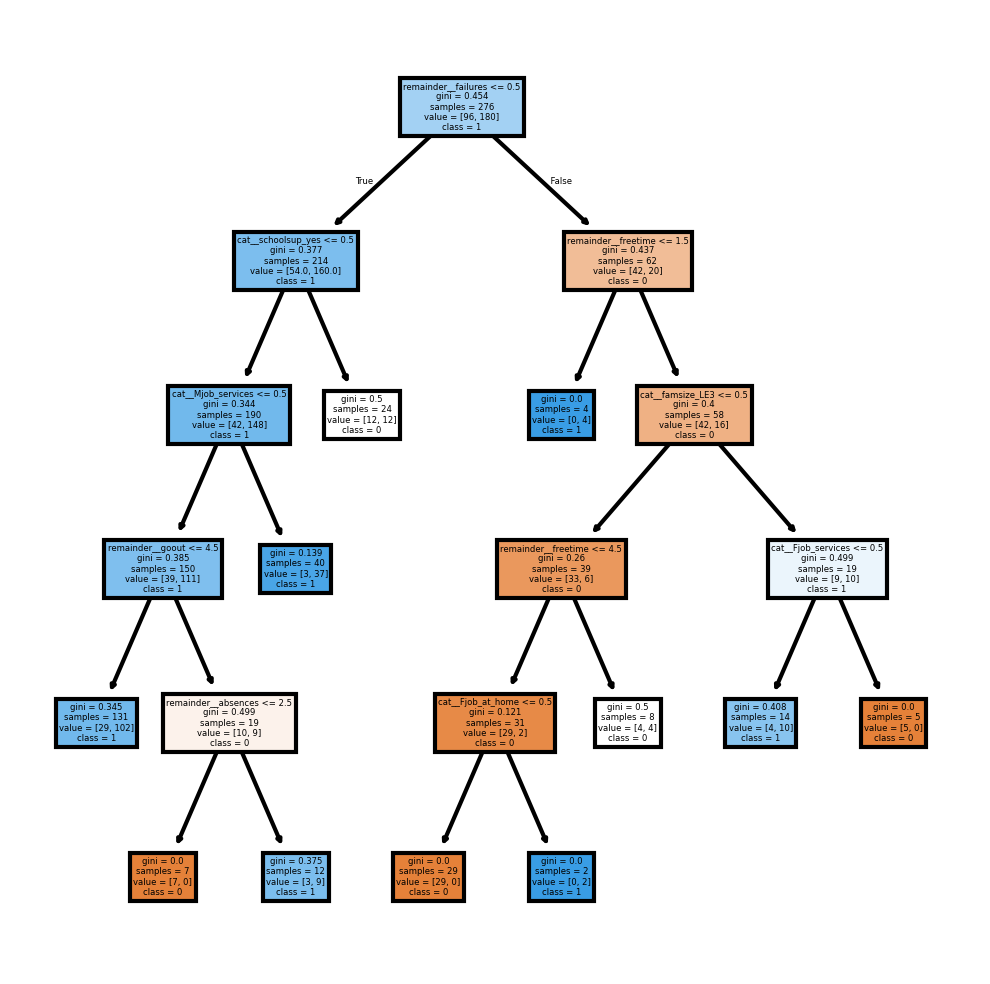

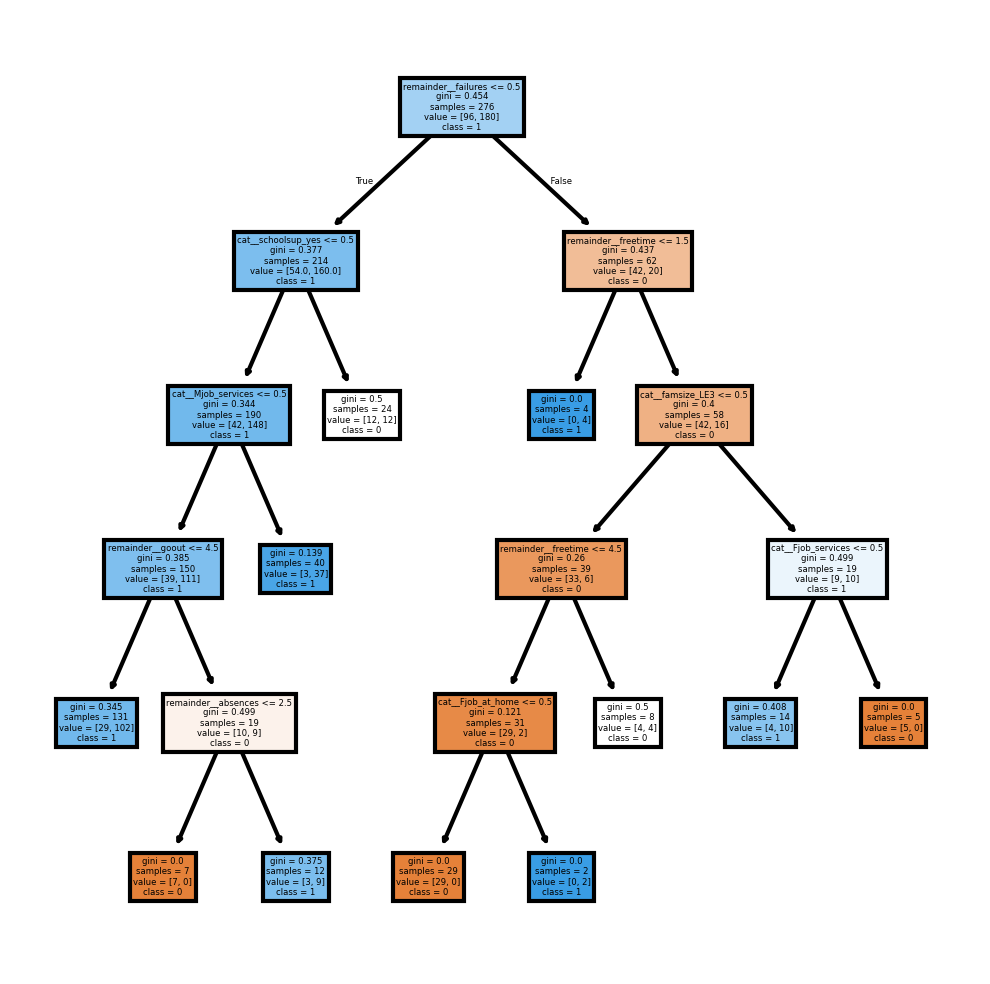

In [10]:
# visualise tree
dt = DecisionTreeClassifier(ccp_alpha=0.01,random_state=67)
dt_vis=dt.fit(X_train_preprocessed,y_train)
fn=X_train_preprocessed_df.columns
cn=['0','1']
fig, axes = subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(dt_vis,
               feature_names = fn, 
               class_names=cn,
               filled = True)
fig

## Random forest

In [11]:
# set tuning values
tuned_parameters = [{"max_features": [5,10,20,30,40,50,"sqrt"]}]
rfCV = GridSearchCV(RandomForestClassifier(n_estimators=500,bootstrap=True,oob_score=True,random_state=0), tuned_parameters, scoring='accuracy',cv=10)
# more details see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
rfCV.fit(X_train_preprocessed_df, y_train)
print("Best parameters set found on validation set:")
print()
print(rfCV.best_params_)
print()
print("Grid scores on validation set:")
print()
means = rfCV.cv_results_["mean_test_score"]
stds = rfCV.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, rfCV.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std, params))

Best parameters set found on validation set:

{'max_features': 20}

Grid scores on validation set:

0.699 (+/-0.050) for {'max_features': 5}
0.713 (+/-0.065) for {'max_features': 10}
0.721 (+/-0.068) for {'max_features': 20}
0.713 (+/-0.068) for {'max_features': 30}
0.702 (+/-0.072) for {'max_features': 40}
0.713 (+/-0.073) for {'max_features': 50}
0.710 (+/-0.056) for {'max_features': 'sqrt'}


In [12]:
# predict test set labels
ypred_rf = rfCV.predict(X_test_preprocessed_df)
accuracy_score(y_test,ypred_rf)

0.7058823529411765

In [13]:
confusion_table(ypred_tree, y_test)

Truth,0,1
Predicted,,
0,12,22
1,22,63


In [14]:
'''
yscores_rf = rfCV.predict_proba(X_test_preprocessed_df) #obtain AUC value
roc_auc_score(y_test,yscores_rf,multi_class="ovr",average="micro")
'''

'\nyscores_rf = rfCV.predict_proba(X_test_preprocessed_df) #obtain AUC value\nroc_auc_score(y_test,yscores_rf,multi_class="ovr",average="micro")\n'

In [15]:
# get variable importance, e.g. mean decrease in gini index
rf = RandomForestClassifier(n_estimators=500,max_features=10,bootstrap=True,oob_score=True,random_state=0).fit(X_train_preprocessed_df,y_train)
rf_importances = rf.feature_importances_

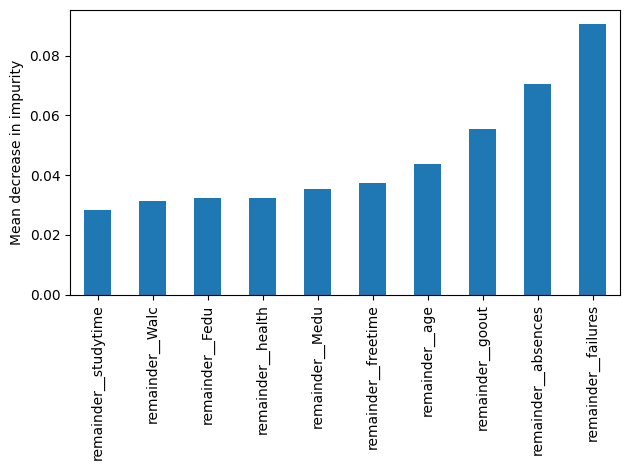

In [16]:
#plot the most important features
index = np.argsort(rf_importances)
forest_importances = pd.Series(rf_importances[index[-10:]], index=rf.feature_names_in_[index[-10:]])

fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## AdaBoost

In [17]:
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=100, random_state=0)
# more details see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
# set tuning values
tuned_parameters = [{"learning_rate": [0.001,0.01,0.1,1]}]
adaCV = GridSearchCV(ada, tuned_parameters, scoring='accuracy',cv=10)
adaCV.fit(X_train_preprocessed_df, y_train)
print("Best parameters set found on validation set:")
print()
print(adaCV.best_params_)
print()
print("Grid scores on validation set:")
print()
means = adaCV.cv_results_["mean_test_score"]
stds = adaCV.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, adaCV.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std, params))

/Users/santos/.pyenv/versions/fintec/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/santos/.pyenv/versions/fintec/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/santos/.pyenv/versions/fintec/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/santos/.pyenv/versions/fintec/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be remov

Best parameters set found on validation set:

{'learning_rate': 0.01}

Grid scores on validation set:

0.713 (+/-0.072) for {'learning_rate': 0.001}
0.724 (+/-0.052) for {'learning_rate': 0.01}
0.667 (+/-0.061) for {'learning_rate': 0.1}
0.681 (+/-0.070) for {'learning_rate': 1}


/Users/santos/.pyenv/versions/fintec/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/santos/.pyenv/versions/fintec/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [18]:
# predict test set labels
ypred_ada = adaCV.predict(X_test_preprocessed_df)
accuracy_score(y_test,ypred_ada)

0.6974789915966386

In [19]:
confusion_table(ypred_ada, y_test)

Truth,0,1
Predicted,,
0,9,11
1,25,74


In [20]:
'''
yscores_ada = adaCV.predict_proba(X_test_preprocessed_df) #obtain AUC value
roc_auc_score(y_test,yscores_ada,multi_class="ovr",average="micro")
'''

'\nyscores_ada = adaCV.predict_proba(X_test_preprocessed_df) #obtain AUC value\nroc_auc_score(y_test,yscores_ada,multi_class="ovr",average="micro")\n'

## Gradient Boosting

In [21]:
grd = GradientBoostingClassifier(max_depth=3, n_estimators=100, random_state=0)
# more details see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
# set tuning values
tuned_parameters = [{"learning_rate": [0.001,0.01,0.1,1]}]
grdCV = GridSearchCV(grd, tuned_parameters, scoring='accuracy',cv=10)
grdCV.fit(X_train_preprocessed_df, y_train)
print("Best parameters set found on validation set:")
print()
print(grdCV.best_params_)
print()
print("Grid scores on validation set:")
print()
means = grdCV.cv_results_["mean_test_score"]
stds = grdCV.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, grdCV.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std, params))

Best parameters set found on validation set:

{'learning_rate': 0.01}

Grid scores on validation set:

0.652 (+/-0.012) for {'learning_rate': 0.001}
0.721 (+/-0.061) for {'learning_rate': 0.01}
0.695 (+/-0.051) for {'learning_rate': 0.1}
0.637 (+/-0.092) for {'learning_rate': 1}


In [22]:
# predict test set labels
ypred_grd = grdCV.predict(X_test_preprocessed_df)
accuracy_score(y_test,ypred_grd)

0.6890756302521008

In [23]:
confusion_table(ypred_grd, y_test)

Truth,0,1
Predicted,,
0,7,10
1,27,75


In [24]:
'''
yscores_grd = grdCV.predict_proba(X_test_preprocessed_df) #obtain AUC value
roc_auc_score(y_test,yscores_grd,multi_class="ovr",average="micro")
'''

'\nyscores_grd = grdCV.predict_proba(X_test_preprocessed_df) #obtain AUC value\nroc_auc_score(y_test,yscores_grd,multi_class="ovr",average="micro")\n'

In [25]:
# get variable importance, e.g. mean decrease in gini index
grd = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=100, random_state=0).fit(X_train_preprocessed_df,y_train)
grd_importances = grd.feature_importances_

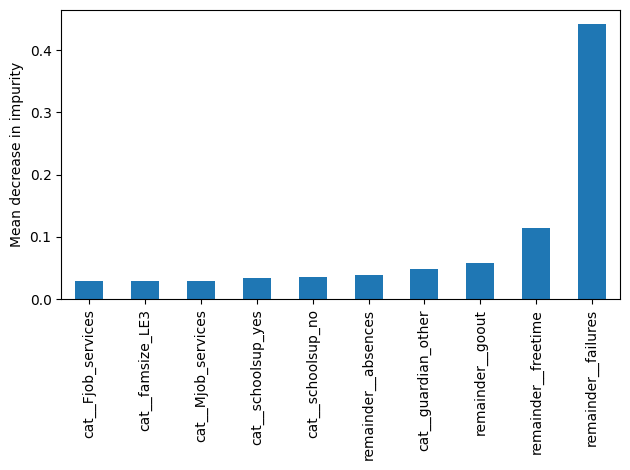

In [26]:
#plot the most important features
grd_index = np.argsort(grd_importances)
boosting_importances = pd.Series(grd_importances[grd_index[-10:]], index=grd.feature_names_in_[grd_index[-10:]])

fig, ax = plt.subplots()
boosting_importances.plot.bar()
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()